In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Image Preprocessing

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

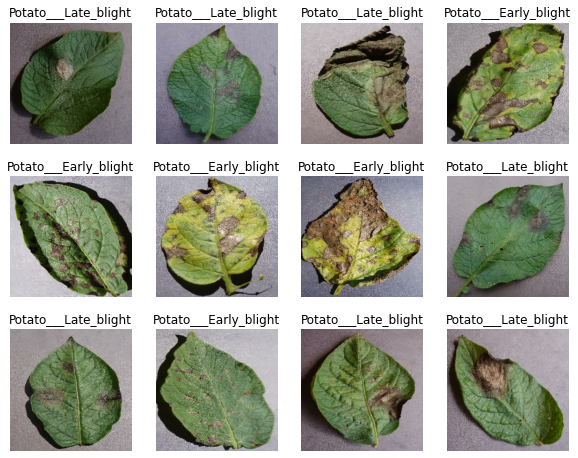

In [5]:
plt.figure(figsize=(10,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        #print(image_batch.shape)
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.savefig('dataset.png')

        #print(label_batch.numpy())

In [6]:
len(dataset)

68

80% ==> training
20% ==> 10% validation, 10% test

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
remaining_ds = dataset.skip(54)

In [10]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = remaining_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = remaining_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/25
54/54 [==============================] - 504s 8s/step - loss: 0.8973 - accuracy: 0.4711 - val_loss: 0.7903 - val_accuracy: 0.5312
Epoch 2/25
54/54 [==============================] - 389s 7s/step - loss: 0.7330 - accuracy: 0.6337 - val_loss: 0.5683 - val_accuracy: 0.7135
Epoch 3/25
54/54 [==============================] - 302s 6s/step - loss: 0.5136 - accuracy: 0.7662 - val_loss: 0.3792 - val_accuracy: 0.8802
Epoch 4/25
54/54 [==============================] - 341s 6s/step - loss: 0.3184 - accuracy: 0.8733 - val_loss: 0.1651 - val_accuracy: 0.9323
Epoch 5/25
54/54 [==============================] - 308s 6s/step - loss: 0.2462 - accuracy: 0.8987 - val_loss: 0.1917 - val_accuracy: 0.9219
Epoch 6/25
54/54 [==============================] - 321s 6s/step - loss: 0.2322 - accuracy: 0.9132 - val_loss: 0.2002 - val_accuracy: 0.9219
Epoch 7/25
54/54 [==============================] - 356s 7s/step - loss: 0.1608 - accuracy: 0.9404 - val_loss: 0.1542 - val_accuracy: 0.9531
Epoch 8/25
54

# Prediction and Save

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 137s 1s/step - loss: 0.1764 - accuracy: 0.9414
Test Accuracy: 94.14%


In [61]:
class_names
classes = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [72]:
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

8/8 [==============================] - 9s 1s/step


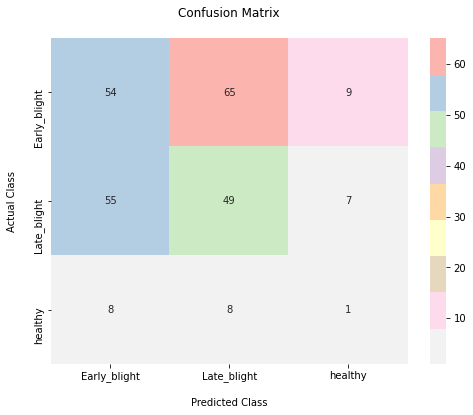

In [102]:
import seaborn as sns

plt.figure(figsize=(8, 6))

cf_matrix = confusion_matrix(predicted_categories, true_categories)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Pastel1_r')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class\n');

ax.xaxis.set_ticklabels(['Early_blight', 'Late_blight', 'healthy'])
ax.yaxis.set_ticklabels(['Early_blight', 'Late_blight', 'healthy'])

plt.savefig('confusion_matrix.png')
plt.show()

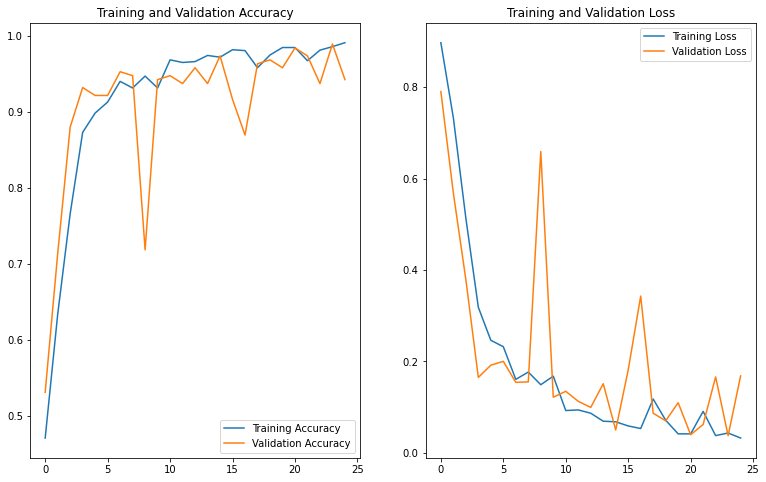

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(13, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy.png')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('loss.png')
plt.show()

In [51]:
y_pred=model.predict_classes(test_ds)
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

1/1 [==============================] - 1s 1s/step


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 18s 18s/step
predicted label: Potato___Late_blight


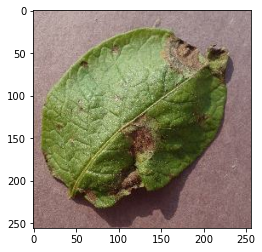

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


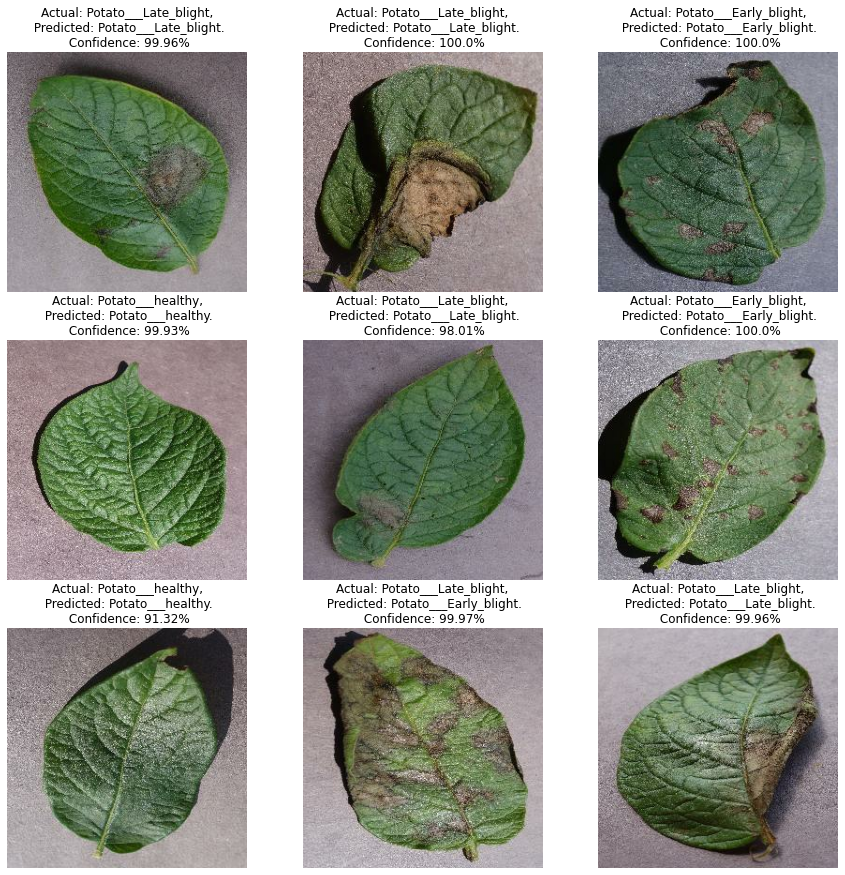

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
        #plt.savefig('predicted.png')

In [34]:
import os
model_version = max([int(i) for i in (os.listdir("../saved_models")+[0])])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [35]:
model.save("../potatoes.h5")

Save History and load

In [45]:
np.save('my_history.npy',history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
model = keras.models.load_model('../potatoes.h5')